# Fetal skin object basic pre-processing and integration

##### Ver:: A1_V1
##### Author(s) : Issac Goh
##### Date : 220523;DDMMYY
### Author notes
    - Due to time contraints, data is being processed using the previously sliced raw expression matrix
    - Previous QC removed 60,000 cells from the raw reads
    - We will proceed with the sliced-raw-expression data of ~185,000 cells and only consider the exprrssion variation amongst these cells
    - Feature normalisation & standardisation does not include cells filtered-out
    
### Assumptions
    - We assume that the major contributors to batch are chemistry and donor information

### Features summary
    - The learned latent representation should encode unique variational composition
    - Due to time constraints, we do not test if this unique variational composition encodes sufficient information to provide accurate decision boundaries between celltype categories
    
### Modes to run in
    - Run in VAE-scvi mode
    - Run in linear-decoded VAE mode

In [14]:
import sys,os
import scvi
import anndata
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import numpy as np3
import pandas as pd
import scanpy as sc
import numpy.random as random
import scipy.sparse
import anndata
import numpy as np
from collections import Counter
from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
import torch
device = torch.device("cuda")

# Define _obj paths

In [3]:
# obj paths
data = {
'fski_raw':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/FS_new_Gene_raw_sliced_raw.h5ad', # Object containing raw counts pre-QC slicing
'fski_qc_raw':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/FS_new_Gene_raw_sliced_processed.h5ad', # Object containing raw counts post-QC slicing
'fskin_NI_raw':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/fetal_skin_raw.h5ad',
'fskin_NI_QC_maternal_removed':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/fetal_skin.norm.maternal_removed.20220202.h5ad', # previous Ni's filtered ver of the obj with QC removed
'fski_qc_norm':'/nfs/team205/ig7/projects/fetal_skin/data/A1_V1_FS_new_Gene_norm_qc_sliced.h5ad',
'fski_qc_norm_scvi':'/nfs/team205/ig7/projects/fetal_skin/data/A1_V1_FS_new_Gene_norm_qc_sliced_scvi.h5ad',
#'fski_qc_norm_ldvae':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/A1_V1_FS_new_Gene_norm_qc_ldvae.h5ad',
}

# Define run path

In [4]:
run_id = 'A1_V1_FS_new_Gene_norm_qc_sliced_scvi'
# Required: Introduce the path you'd like to save figures or data to 
save_path = "/nfs/team205/ig7/projects/fetal_skin/data/"

# Data loader

In [85]:
data_merge = False
QC_normalise = True #Shoud not affect total number of cells in this instance
data_key_use = 'fski_qc_raw'
var_key = 'independent_annotation_refined_20220202'
batches = ['donor','chemistry'] # In order of prior assumed priortiy (asumption not based in testing or optimisation)
save_norm_key = 'fski_qc_norm'

# Parameter sweep for integration
param_sweep = False 
# If param_sweep is false the last value of the list is taken
nhvgs = [5000,7500,10000]
dims = [10,20,30]

# Use linear decoding?
lin_vae = False

In [8]:
def load_adatas(adatas_dict,data_merge, data_key_use,QC_normalise,backed=None):
    if data_merge == True:
        # Read
        gene_intersect = {} # unused here
        adatas = {}
        for dataset in adatas_dict.keys():
            if 'https' in adatas_dict[dataset]:
                print('Loading anndata from web source')
                adatas[dataset] = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[dataset])
            print('Loading anndata {} from local source'.format(dataset))
            adatas[dataset] = sc.read(adatas_dict[dataset],backed)
            adatas[dataset].var_names_make_unique()
            adatas[dataset].obs['dataset_merge'] = dataset
            adatas[dataset].obs['dataset_merge'] = dataset
#             adatas[dataset].obs.index = adatas[dataset].obs.index + dataset
            gene_intersect[dataset] = list(adatas[dataset].var.index)
            print('All datasets successfully read into a dictionary')
        print('Attempting to collapse dictionary into single joint concatenation')
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner',index_unique=None) # consider only genes that are intersecting
        return adatas, adata
    elif data_merge == False:
        if 'https' in adatas_dict[data_key_use]:
            print('Loading anndata from web source')
            adata = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[data_key_use])
        else: 
            print('Loading anndata {} from local source'.format(data_key_use))
            adata = sc.read(adatas_dict[data_key_use],backed)
    if QC_normalise == True:
        print('option to apply standardisation to data detected, performing basic QC filtering')
        print('Warning we have not implemented a norm check here, so we assume your inut here is raw!')
        adata.raw = adata[:]
        print('Anndata shape is {}'.format(adata.shape))
        #sc.pp.filter_cells(adata, min_genes=200) # No cell filters heren as we want the same [0] dimension as previous analyses
        #sc.pp.filter_genes(adata, min_cells=10) # 
        print('QC filtered Anndata shape is {}'.format(adata.shape))
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        sc.pp.log1p(adata)
    return adata

def find_sc_distr(adata_fil_,num_random_cells):
    distr = []
    print("Testing the per-cell expression distribution for {} randomly sampled cells".format(num_random_cells))
    idx_c = np.random.choice(adata_fil_.shape[0], size= num_random_cells, replace=False, p=None) #int(adata_fil_.shape[1]/10)
    for cell in idx_c:
        mtx_s_ = adata_fil_[cell].X.todense()
        f = Fitter(mtx_s_,distributions=['expon','lognorm',"norm"])
        f.fit()
        f.summary()
        distr = distr + list(f.get_best(method = 'sumsquare_error').keys())
    print(dict(Counter(distr)))
    if np.min(mtx_s_) >= 0:
        print("The most likely distribution is {}".format(max(dict(Counter(distr)))))
    else:
         print("There are some negative values, data might be scaled, the most likely distribution is {}".format(max(dict(Counter(distr)))))
    distr_guide = {
    'lognorm':'This is most likely if the data has been log transformed but perhaps not normlaised prior',
    'norm':'This is the most liklely distribution for normalised scRNA-seq data',
    'expo':'This is the most liklely distribution for log-norm and raw scRNA-seq data',
    }
    print(distr_guide)
    return distr

In [7]:
# Read
adata_raw = load_adatas(data, data_merge ,data_key_use, QC_normalise)

# Slice to only contain processed
    # adata_raw = adata_raw.obs['isin_processed']

# Write the norm-log data as h5ad file for posterity
adata_raw.write(data[save_norm_key])

Loading anndata fski_qc_raw from local source
option to apply standardisation to data detected, performing basic QC filtering
Warning we have not implemented a norm check here, so we assume your inut here is raw!
Anndata shape is (186533, 36601)
QC filtered Anndata shape is (186533, 28264)


# View some QC metrics
- This data shouyld be pre-filtered and we don't want to change anything so we'll just take a look
- We may choose to apply per-lane dynamic threshold in future
- We may also choose to perform some simple K-iterations clustering to determine which variable (runs/lanes/donors) are most significantly associated with outliers

**Observations**
- I note that the MT cut-off is  very low max == 11.955, basal KCs and other highly metabolically active cells usually have higher MT content
- Upper limit of total counts is capped at ~4170 which may be biased for cells with higher RNA content, however, from the graph, this does look like a natural cutoff. If intent was to remove doublets, this can be done by signature later
- Lower limit of n_genes is very low ~70 ngenes_by_counts

**Suggestions**
- Apply an MAD cutoff for dynamic thresholding of MT upperbound and n_genes_by_counts lower bound. (Median +/- 1.48 MAD)

# Filter parameter detection module
- This module takes as input a filtered dataset and it's raw precursor
- The output is an approximation of the thresholds used to derive the filtered data
- The module then tests if these parameters are sufficient to reproduce the filtered output
- If it detects an annomally, it will report as insufficient information, this suggests a layer of supervised work

In [80]:
# Params
filtered = 'fskin_NI_QC_maternal_removed'
raw = 'fskin_NI_raw'
data_dic = data
num_random_cells = 50 #parameter to sample a random number of cells to determine the expression distribution
lane_information = 'sanger_id'
apply_qc_per_lane = False

Loading anndata fskin_NI_raw from local source
Loading anndata fskin_NI_QC_maternal_removed from local source
Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].
Testing the per-cell expression distribution for 50 randomly sampled cells


Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00,  7.38it/s]


{'expon': 50}
The most likely distribution is expon
{'lognorm': 'This is most likely if the data has been log transformed but perhaps not normlaised prior', 'norm': 'This is the most liklely distribution for normalised scRNA-seq data', 'expo': 'This is the most liklely distribution for log-norm and raw scRNA-seq data'}


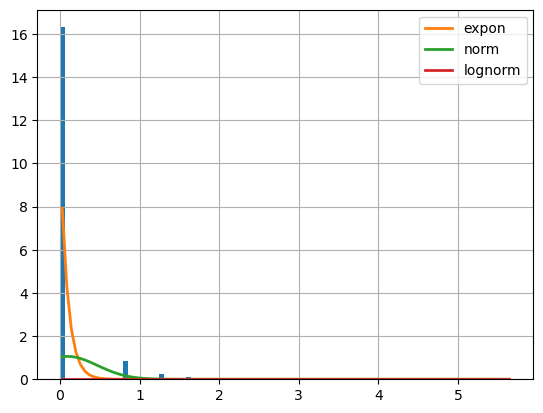

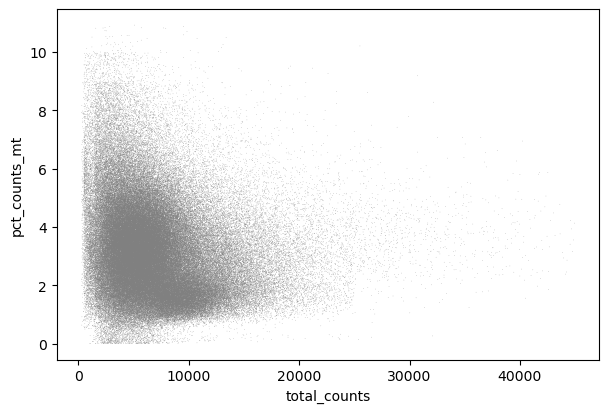

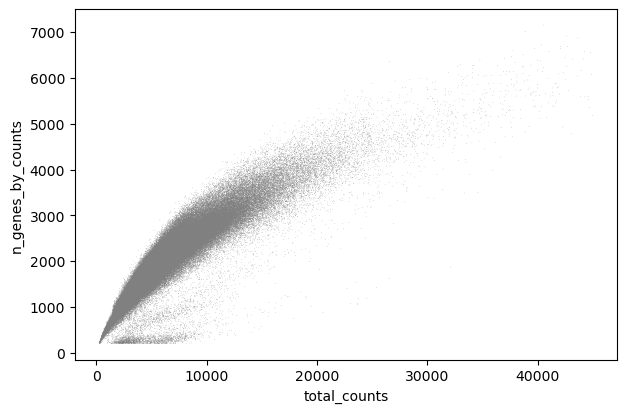

{'mt_high': 10.928318977355957, 'mt_low': 0.0, 'tt_c_high': 44930.0, 'tt_c_low': 300.0, 'ngene_high': 7152, 'ngene_low': 200, 'min_cells_per_gene': 2, 'min_count_per_gene': 0.0}
Apply the above thresholds to raw data
filtered raw shape is (218486, 29580)
Processed data shape is (186533, 28885)
Supervised removal may explain the further loss of 31953 cells and 695 genes


In [95]:
# read raw as backed
adata_raw_ = load_adatas(data_dic, data_merge=False ,data_key_use=raw, QC_normalise = False)
# read QC filtered as copy in memory
adata_fil_ = load_adatas(data_dic, data_merge=False ,data_key_use=filtered, QC_normalise = False)
# Find the most likely distribution of expression per cell. We don;t test between cells so we don't know if scaling has occured, but we assume that if min >=0, it is not scaled
distribution = find_sc_distr(adata_fil_,num_random_cells)

if apply_qc_per_lane == True:
    # consider per lane
    idx_keep = []
    for ln_id in adata_fil_.obs[lane_information].unique():
        adata_fil_tmp = adata_fil_[adata_fil_.obs[lane_information].isin([ln_id])]
        adata_raw_tmp = adata_raw_[adata_raw_.obs[lane_information].isin([ln_id])]

        # give the filtered data, raw coiunts
        adata_raw_tmp.var['mt'] = adata_raw_tmp.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
        sc.pp.calculate_qc_metrics(adata_raw_tmp, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        adata_raw_fil_ = adata_raw_tmp[adata_raw_tmp.obs.index.isin(adata_fil_tmp.obs.index)]
        adata_fil_tmp.raw = adata_raw_fil_
        adata_fil_tmp.X = adata_raw_fil_[:,adata_fil_tmp.var.index].X
        # Find common threshold boundarties
        adata_fil_tmp.var['mt'] = adata_fil_tmp.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
        sc.pp.calculate_qc_metrics(adata_fil_tmp, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        thresh_dict = {}
        thresh_dict['mt_high'] = np.max(adata_fil_tmp.obs['pct_counts_mt'])
        thresh_dict['mt_low'] = np.min(adata_fil_tmp.obs['pct_counts_mt'])
        thresh_dict['tt_c_high'] = np.max(adata_fil_tmp.obs['total_counts'])
        thresh_dict['tt_c_low'] = np.min(adata_fil_tmp.obs['total_counts'])
        thresh_dict['ngene_high'] = np.max(adata_fil_tmp.obs['n_genes_by_counts'])
        thresh_dict['ngene_low'] = np.min(adata_fil_tmp.obs['n_genes_by_counts'])
        rm_genes = list(set(list(adata_fil_tmp.raw.var.index)) ^ set(list(adata_fil_tmp.var.index)))
        adata_raw_fil_var = adata_raw_fil_[:,rm_genes].var
        thresh_dict['min_cells_per_gene']  = np.max(adata_raw_fil_var['n_cells_by_counts'])
        thresh_dict['min_count_per_gene']  =  np.min(adata_fil_tmp.var['total_counts'])
        print(thresh_dict)
        print('Apply the above thresholds to raw data')
        sc.pp.filter_genes(adata_raw_,min_cells=thresh_dict['min_cells_per_gene'])
        adata_raw_tmp = adata_raw_tmp[:,adata_raw_tmp.var[adata_raw_tmp.var['total_counts']>thresh_dict['min_count_per_gene']].index]
        adata_raw_tmp = adata_raw_tmp[adata_raw_tmp.obs['pct_counts_mt'] < thresh_dict['mt_high']]
        adata_raw_tmp = adata_raw_tmp[adata_raw_tmp.obs['total_counts'] > thresh_dict['tt_c_low']]
        adata_raw_tmp = adata_raw_tmp[adata_raw_tmp.obs['total_counts'] < thresh_dict['tt_c_high']]
        adata_raw_tmp = adata_raw_tmp[adata_raw_tmp.obs['n_genes_by_counts'] < thresh_dict['ngene_high']]
        adata_raw_tmp = adata_raw_tmp[adata_raw_tmp.obs['n_genes_by_counts'] > thresh_dict['ngene_low']]
        idx_keep = idx_keep + list(adata_raw_tmp.obs.index)

    adata_raw_fil_new = adata_raw_[adata_raw_.obs.index.isin(idx_keep)]    
    sc.pl.scatter(adata_raw_fil_new, x='total_counts', y='pct_counts_mt')
    sc.pl.scatter(adata_raw_fil_new, x='total_counts', y='n_genes_by_counts')
    print("filtered raw shape is {}".format(adata_raw_fil_new.shape))
    print("Processed data shape is {}".format(adata_fil_.shape))
    print("Supervised removal may explain the further loss of {} cells and {} genes".format(adata_raw_.shape[0] - adata_fil_.shape[0],adata_raw_.shape[1] - adata_fil_.shape[1] ))
    
else:
    # read raw as backed
    adata_raw_ = load_adatas(data_dic, data_merge=False ,data_key_use=raw, QC_normalise = False)
    # read QC filtered as copy in memory
    adata_fil_ = load_adatas(data_dic, data_merge=False ,data_key_use=filtered, QC_normalise = False)
    # Find the most likely distribution of expression per cell. We don;t test between cells so we don't know if scaling has occured, but we assume that if min >=0, it is not scaled
    distribution = find_sc_distr(adata_fil_,num_random_cells)

    # give the filtered data, raw coiunts
    adata_raw_.var['mt'] = adata_raw_.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata_raw_, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata_raw_fil_ = adata_raw_[adata_raw_.obs.index.isin(adata_fil_.obs.index)]
    adata_fil_.raw = adata_raw_fil_
    adata_fil_.X = adata_raw_fil_[:,adata_fil_.var.index].X

    # Find common threshold boundarties
    adata_fil_.var['mt'] = adata_fil_.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata_fil_, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    sc.pl.scatter(adata_fil_, x='total_counts', y='pct_counts_mt')
    sc.pl.scatter(adata_fil_, x='total_counts', y='n_genes_by_counts')

    thresh_dict = {}
    thresh_dict['mt_high'] = np.max(adata_fil_.obs['pct_counts_mt'])
    thresh_dict['mt_low'] = np.min(adata_fil_.obs['pct_counts_mt'])
    thresh_dict['tt_c_high'] = np.max(adata_fil_.obs['total_counts'])
    thresh_dict['tt_c_low'] = np.min(adata_fil_.obs['total_counts'])
    thresh_dict['ngene_high'] = np.max(adata_fil_.obs['n_genes_by_counts'])
    thresh_dict['ngene_low'] = np.min(adata_fil_.obs['n_genes_by_counts'])
    rm_genes = list(set(list(adata_fil_.raw.var.index)) ^ set(list(adata_fil_.var.index)))
    adata_raw_fil_var = adata_raw_fil_[:,rm_genes].var
    thresh_dict['min_cells_per_gene']  = np.max(adata_raw_fil_var['n_cells_by_counts'])
    thresh_dict['min_count_per_gene']  =  np.min(adata_fil_.var['total_counts'])
    print(thresh_dict)
    print('Apply the above thresholds to raw data')
    sc.pp.filter_genes(adata_raw_,min_cells=thresh_dict['min_cells_per_gene'])
    adata_raw_ = adata_raw_[:,adata_raw_.var[adata_raw_.var['total_counts']>thresh_dict['min_count_per_gene']].index]
    adata_raw_ = adata_raw_[adata_raw_.obs['pct_counts_mt'] < thresh_dict['mt_high']]
    adata_raw_ = adata_raw_[adata_raw_.obs['total_counts'] > thresh_dict['tt_c_low']]
    adata_raw_ = adata_raw_[adata_raw_.obs['total_counts'] < thresh_dict['tt_c_high']]
    adata_raw_ = adata_raw_[adata_raw_.obs['n_genes_by_counts'] < thresh_dict['ngene_high']]
    adata_raw_ = adata_raw_[adata_raw_.obs['n_genes_by_counts'] > thresh_dict['ngene_low']]
    print("filtered raw shape is {}".format(adata_raw_.shape))
    print("Processed data shape is {}".format(adata_fil_.shape))
    print("Supervised removal may explain the further loss of {} cells and {} genes".format(adata_raw_.shape[0] - adata_fil_.shape[0],adata_raw_.shape[1] - adata_fil_.shape[1] ))

# Back to pre-processing

<ipython-input-8-53c6c7ac2455>:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


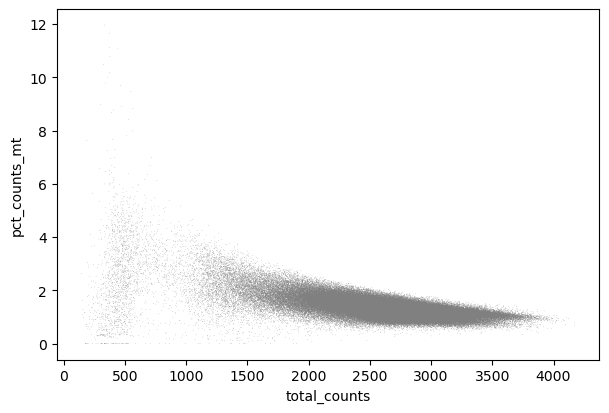

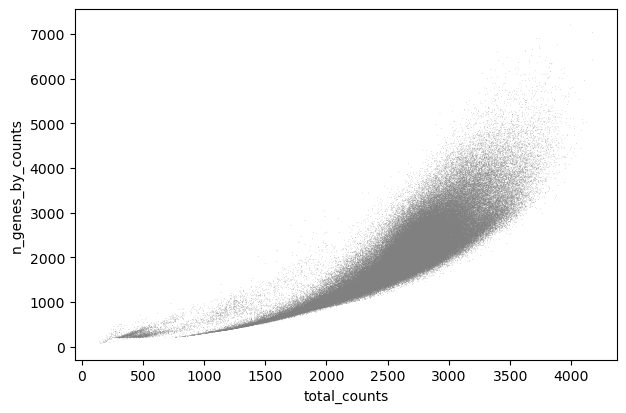

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

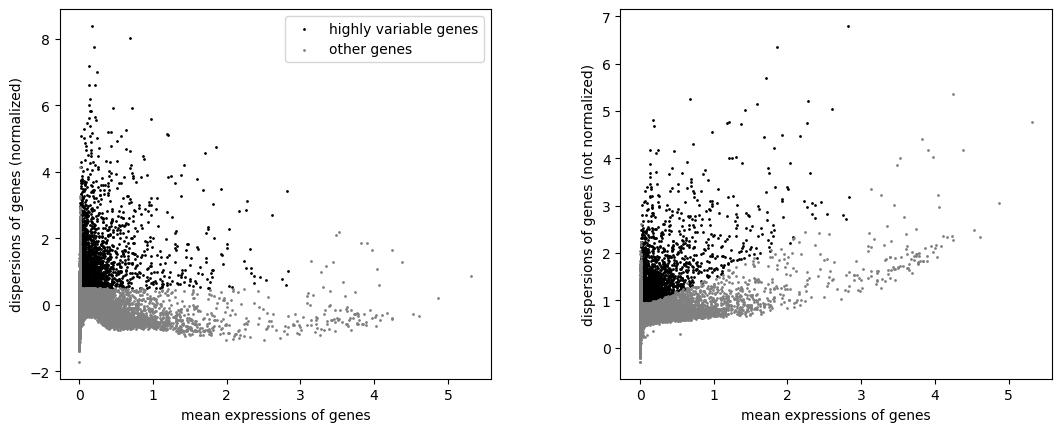

In [22]:
sc.pp.highly_variable_genes(adata, batch_key = batches[0], subset=False)
sc.pl.highly_variable_genes(adata)

In [24]:
import torch
device = torch.device("cuda")

def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

def prep_scVI(adata, 
              n_hvgs = 5000,
              remove_cc_genes = True,
              remove_tcr_bcr_genes = False
             ):
    ## Remove cell cycle genes
    if remove_cc_genes:
        adata = panfetal_utils.remove_geneset(adata,genes.cc_genes)

    ## Remove TCR/BCR genes
    if remove_tcr_bcr_genes:
        adata = panfetal_utils.remove_geneset(adata, genes.IG_genes)
        adata = panfetal_utils.remove_geneset(adata, genes.TCR_genes)
        
    ## HVG selection
    adata = subset_top_hvgs(adata, n_top_genes=n_hvgs)
    return(adata)

def train_scVI(adata, n_dims=20):
    adata = scvi.data.setup_anndata(adata, batch_key = "bbk", copy=True)
    vae = scvi.model.SCVI(adata, n_latent=n_dims)
    vae.train(use_gpu=True, batch_size=256) ## increasing batch size as in retina atlas
    return(vae.get_latent_representation())
    
def save_scVI(adata, 
              timestamp,
              n_hvgs = 5000,
              remove_cc_genes = True,
                remove_tcr_bcr_genes = False,
                n_dims=20
             ):
    outname = run_id.format(t=timestamp, h=n_hvgs, cc=cc, tcr=tcr, n=n_dims)
    np.save(data_dir + outname, adata.obsm["X_scVI"])

def train_ldvae(adata, labels_key,batch, n_dims=20):
    arches_params = dict(
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
    n_hidden=256)
    
    scvi.model.LinearSCVI.setup_anndata(
    adata,
    labels_key = labels_key,
    layer=None,
    batch_key=batch)
    
    vae = scvi.model.LinearSCVI(adata, n_latent=30, **arches_params)
    #vae = scvi.model.SCVI(adata, n_latent=30,n_hidden=256, **arches_params)
    vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=500, 
        batch_size=1024, 
        limit_train_batches=20
       )
    X_scvi = vae.get_latent_representation()
    X_loading = vae.get_loadings()
    adata.obsm['X_scvi'] = X_scvi
    adata.varm['X_scvi'] = X_loading
    sc.pp.neighbors(adata,n_neighbors=15, use_rep='X_scvi', n_pcs = 30)
    return adata 


# Feature selection
#### Optional param sweep for feature selection

In [58]:
if param_sweep == True:
    for n in nhvgs:
        for r in remove:
            adata1 = prep_scVI(adata_raw, n_hvgs=n, remove_cc_genes=None, remove_tcr_bcr_genes=None)
            for d in dims:
                adata1.obsm["X_scVI"] = train_scVI(adata1, n_dims=d)
                save_scVI(adata, timestamp=timestamp, n_hvgs=n, remove_tcr_bcr_genes=None, n_dims=d)
            del adata
            gc.collect()
else:
    adata = subset_top_hvgs(adata,nhvgs[-1])
    var_genes = pd.DataFrame(list(adata.var.index))
    var_genes.to_csv(save_path + '/run_'+ run_id+'_var_genes.csv')
    adata_raw = adata.raw.to_adata()[:,list(adata.var.index)]
    adata_raw.layers['raw_counts'] = adata_raw.X.copy()
    adata_raw.layers['normalised_counts'] = adata.X
    adata = adata_raw

# Run scVI integration
We train using parameters optimized for online update with `scArches`, to be able to add query datasets in the future. Following the [scvi-tools vignette](https://docs.scvi-tools.org/en/stable/user_guide/notebooks/scarches_scvi_tools.html?highlight=encode_covariates#Train-reference).

In [65]:
if lin_vae == True:
    adata.obs['lr_batch'] = adata.obs['lr_batch'] = adata.obs[batches].apply(lambda x: '_'.join(x.dropna().astype(str)), axis=1)
    arches_params = dict(
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
    n_hidden=256)

    scvi.model.LinearSCVI.setup_anndata(
    adata,
    labels_key = 'annot',
    layer=None,
    batch_key='lr_batch')
    vae = scvi.model.LinearSCVI(adata, n_latent=dims[-1], **arches_params)
    vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=500, 
        batch_size=1024, 
        limit_train_batches=20
       )
    X_scvi = vae.get_latent_representation()
    X_loading = vae.get_loadings()
    adata.obsm['X_scvi'] = X_scvi
    adata.varm['X_scvi'] = X_loading
    pd.DataFrame(X_scvi).to_csv(save_path + '/run_'+ run_id+'_linear_ldvae_x_scvi.csv')
    pd.DataFrame(X_loading).to_csv('./linear_ldvae_X_scvi_weights.csv')
else:
    scvi.model.SCVI.setup_anndata(
    adata,
    layer=None,
    categorical_covariate_keys = batches,
    )
    arches_params = dict(
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
    n_hidden=256
    )
    vae = scvi.model.SCVI(adata, n_latent=dims[-1],**arches_params)
    vae.train(early_stopping=True,
            train_size=0.9,
            early_stopping_patience=45,
            max_epochs=250, 
            batch_size=1024, 
            limit_train_batches=20
           )
    X_scvi = vae.get_latent_representation()
    pd.DataFrame(X_scvi).to_csv(save_path + '/run_'+ run_id+'_vae_latent_x_scvi.csv')
    ## Save embedding
    x_scvi = vae.get_latent_representation()
    outname = save_path+run_id+"_ld.npy"
    np.save(outname, x_scvi)
    adata.obsm['X_scvi'] = X_scvi
    # save the reference model
    model_dir = 'ldscvi_PFI_model/'
    if not os.path.exists(save_path + model_dir):
        os.mkdir(save_path + model_dir)
    vae.save(save_path + model_dir, overwrite=True, save_anndata=False)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 250/250: 100%|██████████| 250/250 [2:35:00<00:00, 35.54s/it, loss=2.18e+03, v_num=1]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [2:35:00<00:00, 37.20s/it, loss=2.18e+03, v_num=1]


In [67]:
adata.write(data['fski_qc_norm_scvi'])

### Check convergence

In [77]:
data_dir = save_path
ver_stamp = '20230522_A1_V1'

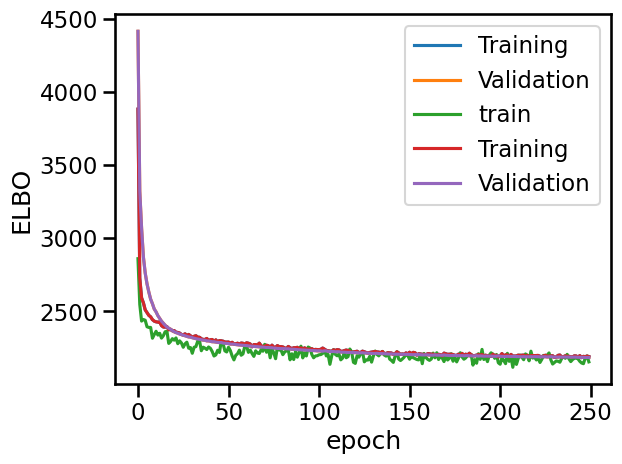

In [78]:
sns.set_context("talk")
plt.plot(vae.history["elbo_train"], label="Training");
plt.plot(vae.history["elbo_validation"], label="Validation");
plt.legend();
plt.xlabel("epoch");
plt.ylabel("ELBO");
plt.savefig("{sp}/scvi_training_elbo.pdf".format(sp = save_path ), bbox_inches="tight")
plt.show()

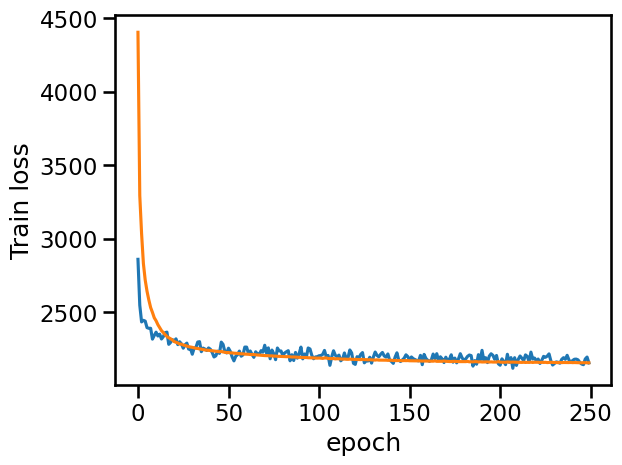

In [79]:
sns.set_context("talk")
plt.plot(vae.history["train_loss_step"], label="train");
plt.plot(vae.history["reconstruction_loss_validation"], label="validation");
plt.xlabel("epoch");
plt.ylabel("Train loss");
plt.show()

In [74]:
## Save training stats
model_history = vae.history.copy()
model_history.pop('train_loss_step')
pd.DataFrame.from_dict({k:v[k] for k,v in model_history.items()}).to_csv("fsk_raw_count.{t}.scVI_out.train_history.csv".format(t=ver_stamp))

# Naive neighborhood embedding
- I am not conducting any optimisation here
- No testing for whether this graph representation can recapitulate the class information is included
- Above options should be included during next round:

**Suggestion**
- In the low-dimensional representation, train a model on the annotated data and recursively project this onto randomly subset queries of the same data. 
- You may wish to employ a majority voting metric over leiden clusters to determine the liklihood of known labels forming descrete clusters given the graph reprsentation

In [88]:
plt.rcdefaults()
sc.set_figure_params(scanpy=False, dpi=150, dpi_save=300, frameon=True, vector_friendly=True, fontsize=14, figsize=[10,10], color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')

# Let's create a analysis visualisation of how well our modelled learned cell-cell variation
#### We will purposefully project the graph into a dispersed manifold

-  We can see that this graph has learnt the variational landscape between immune cells very well
- We also observe that the vartiation which instructs Pre-dermal-dermal condensate trajectory has informed some structuring of this graph.

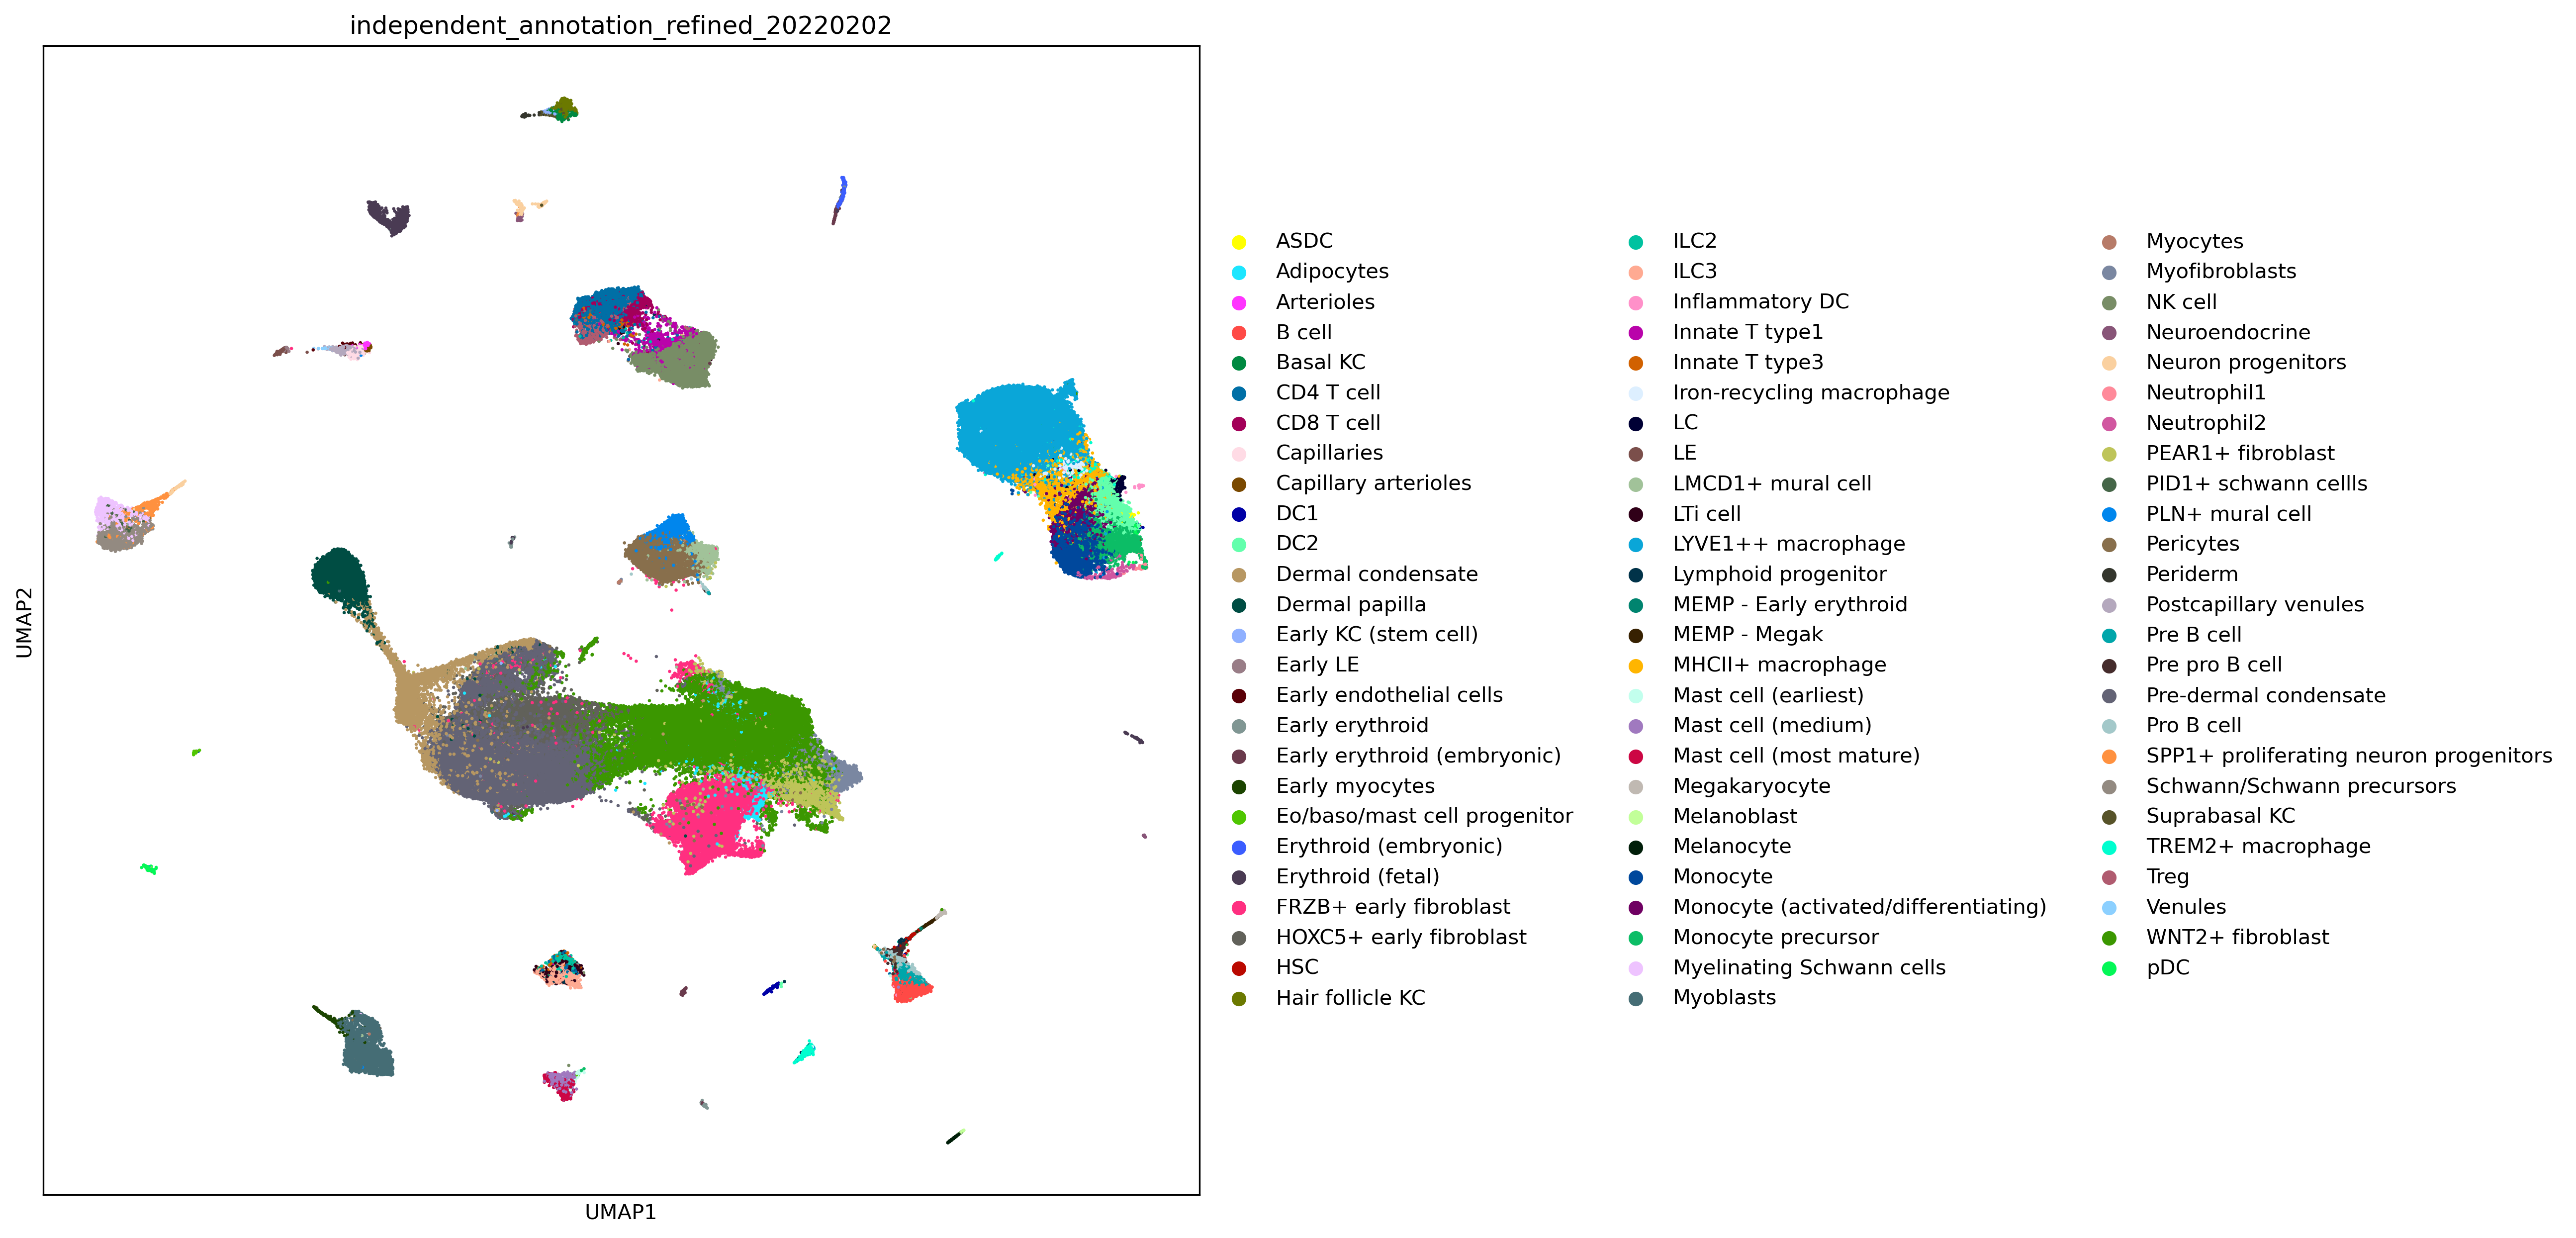

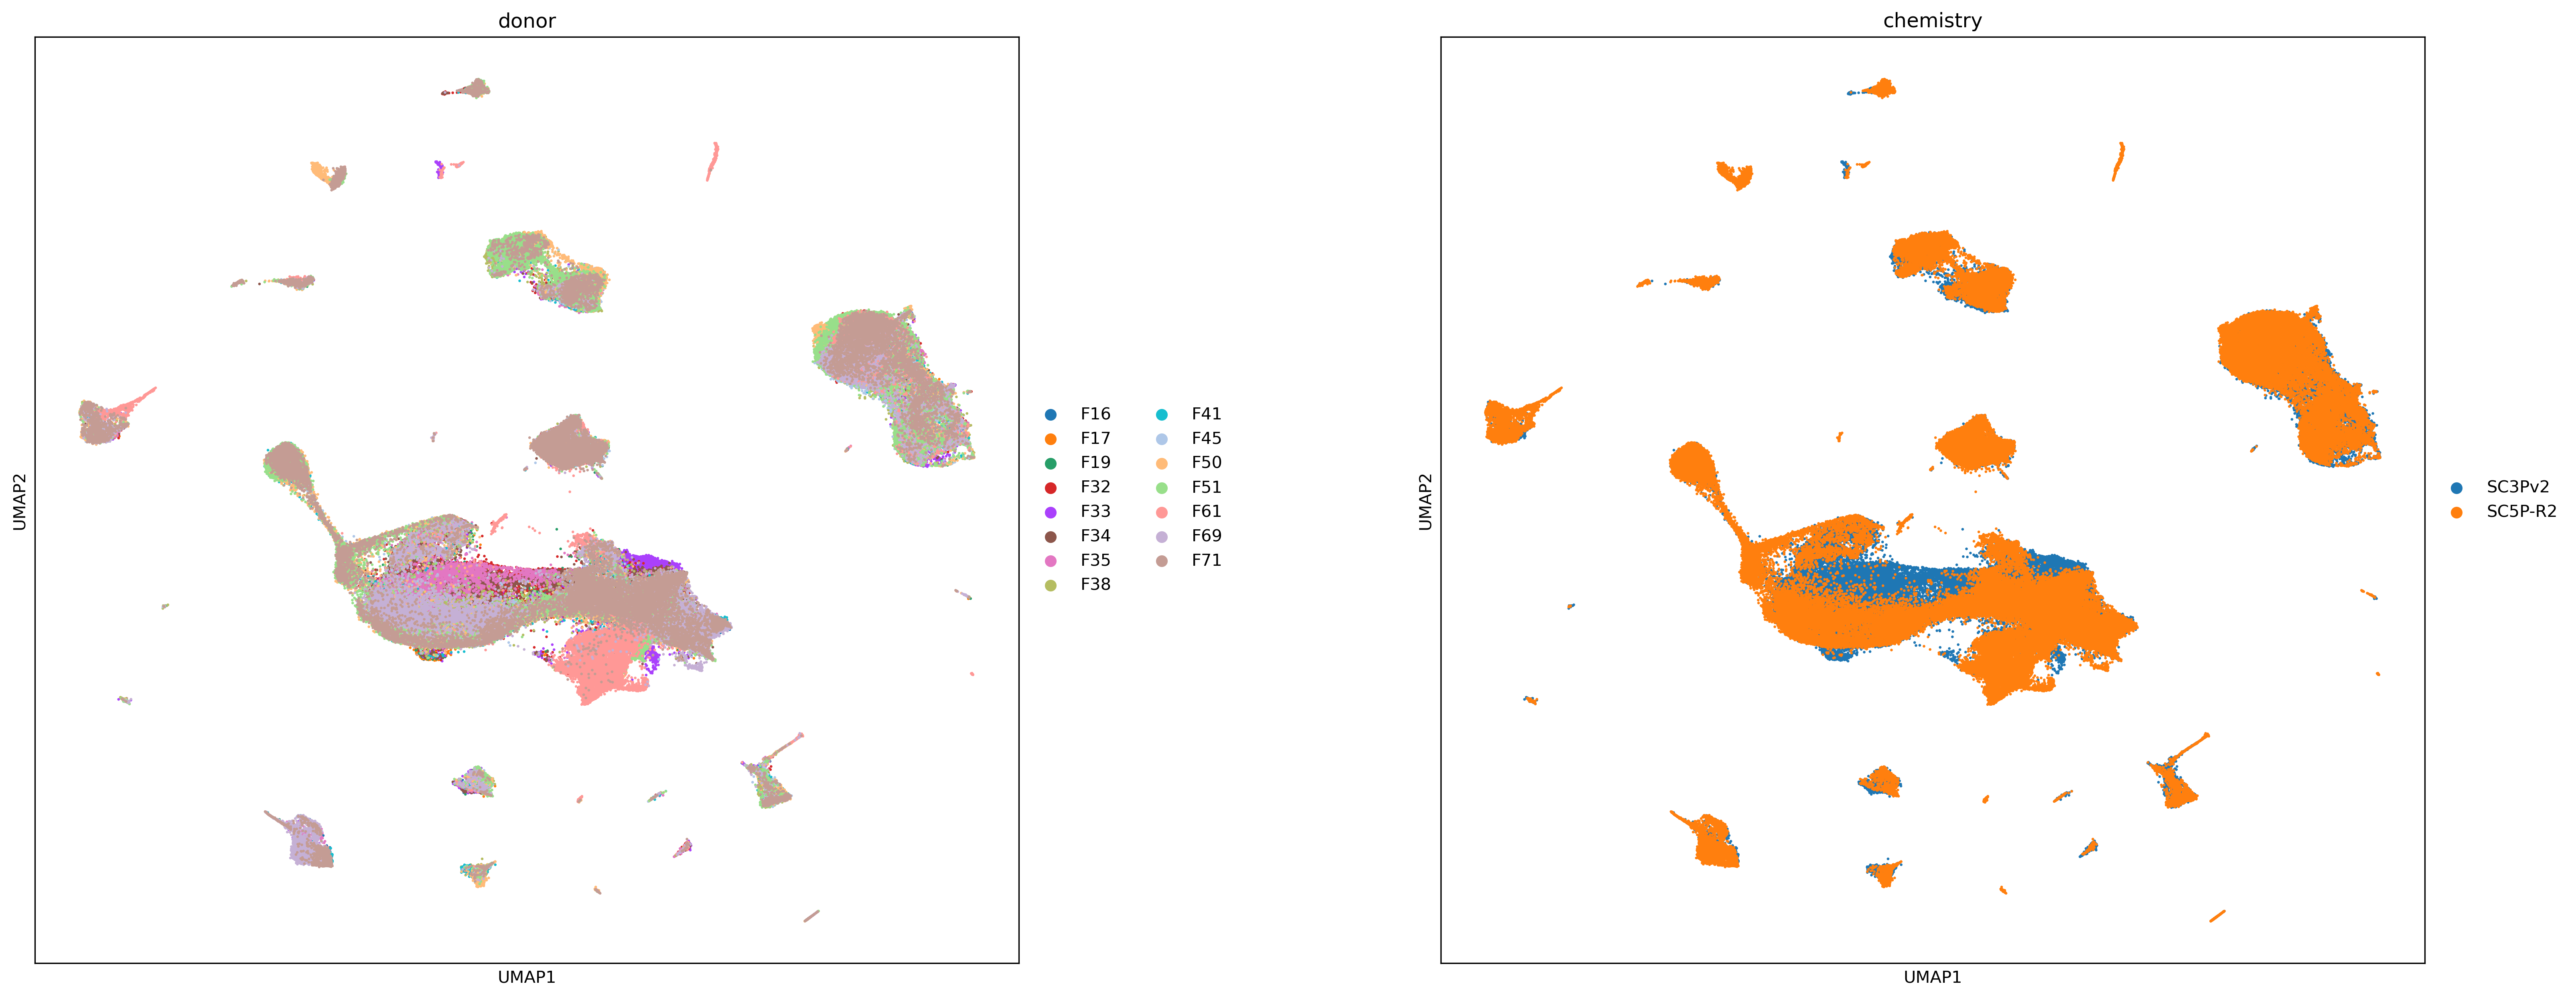

In [92]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs = 20,use_rep = 'X_scvi')
sc.tl.umap(adata, min_dist=0.5, spread=1.0,init_pos='spectral') # Using the default distance scaling from umap-learn
sc.pl.umap(adata,color = var_key,size =10)
sc.pl.umap(adata,color = batches,size =10,wspace=0.3)
adata.obsm['X_umap_disp_01'] = adata.obsm['X_umap']

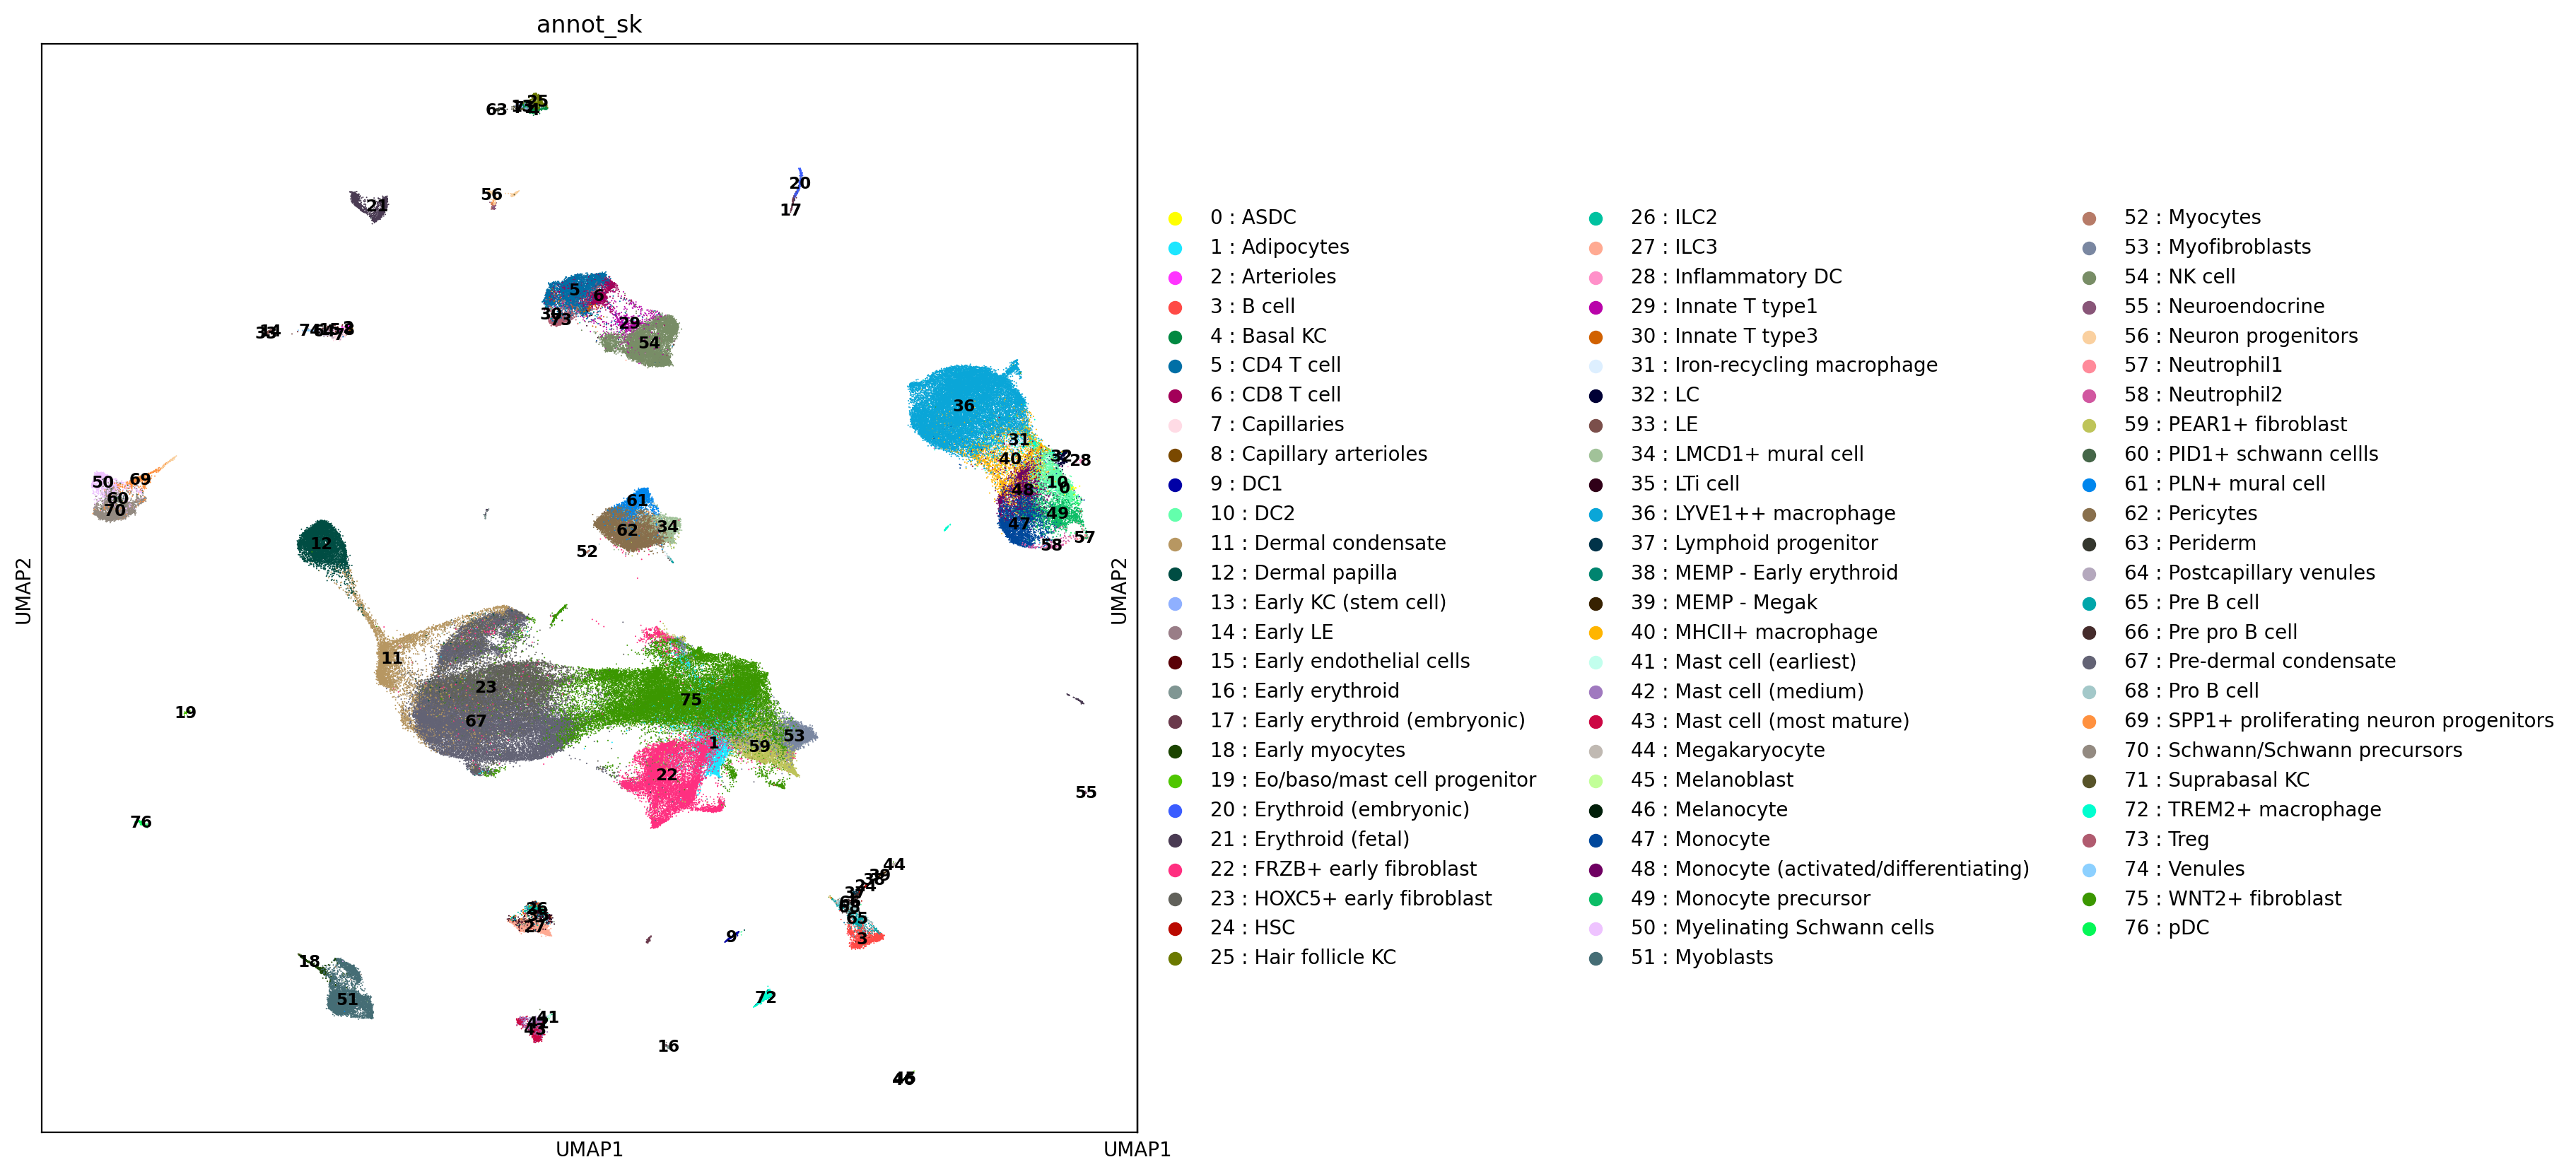

In [97]:
var = var_key
#Create color dictionary_cell
cells = list(adata.obs[var].cat.categories)
col = list(range(0, len(adata.obs[var].cat.categories)))
#col = adata.uns['cell.labels_colors']
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)
col_pal = adata.uns[var_key+'_colors']
plt.rcdefaults() #Reset matplot lb deafults as seaborne tends to mess with this
fig, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1,0]})
p2 = sc.pl.umap(adata, color = (var+'_num') ,ax=ax2,show=False,title="", palette= col_pal) #title=i
p3 = sc.pl.umap(adata, color = "num",legend_loc="on data",size=2,legend_fontsize='small',ax=ax1,show=False,title="annot_sk", palette= col_pal) #title=i
fig.savefig('./'+var+"_num.pdf",bbox_inches='tight')
plt.show()

# We probably want a more compact UMAP

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/umap/spectral.py:348: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


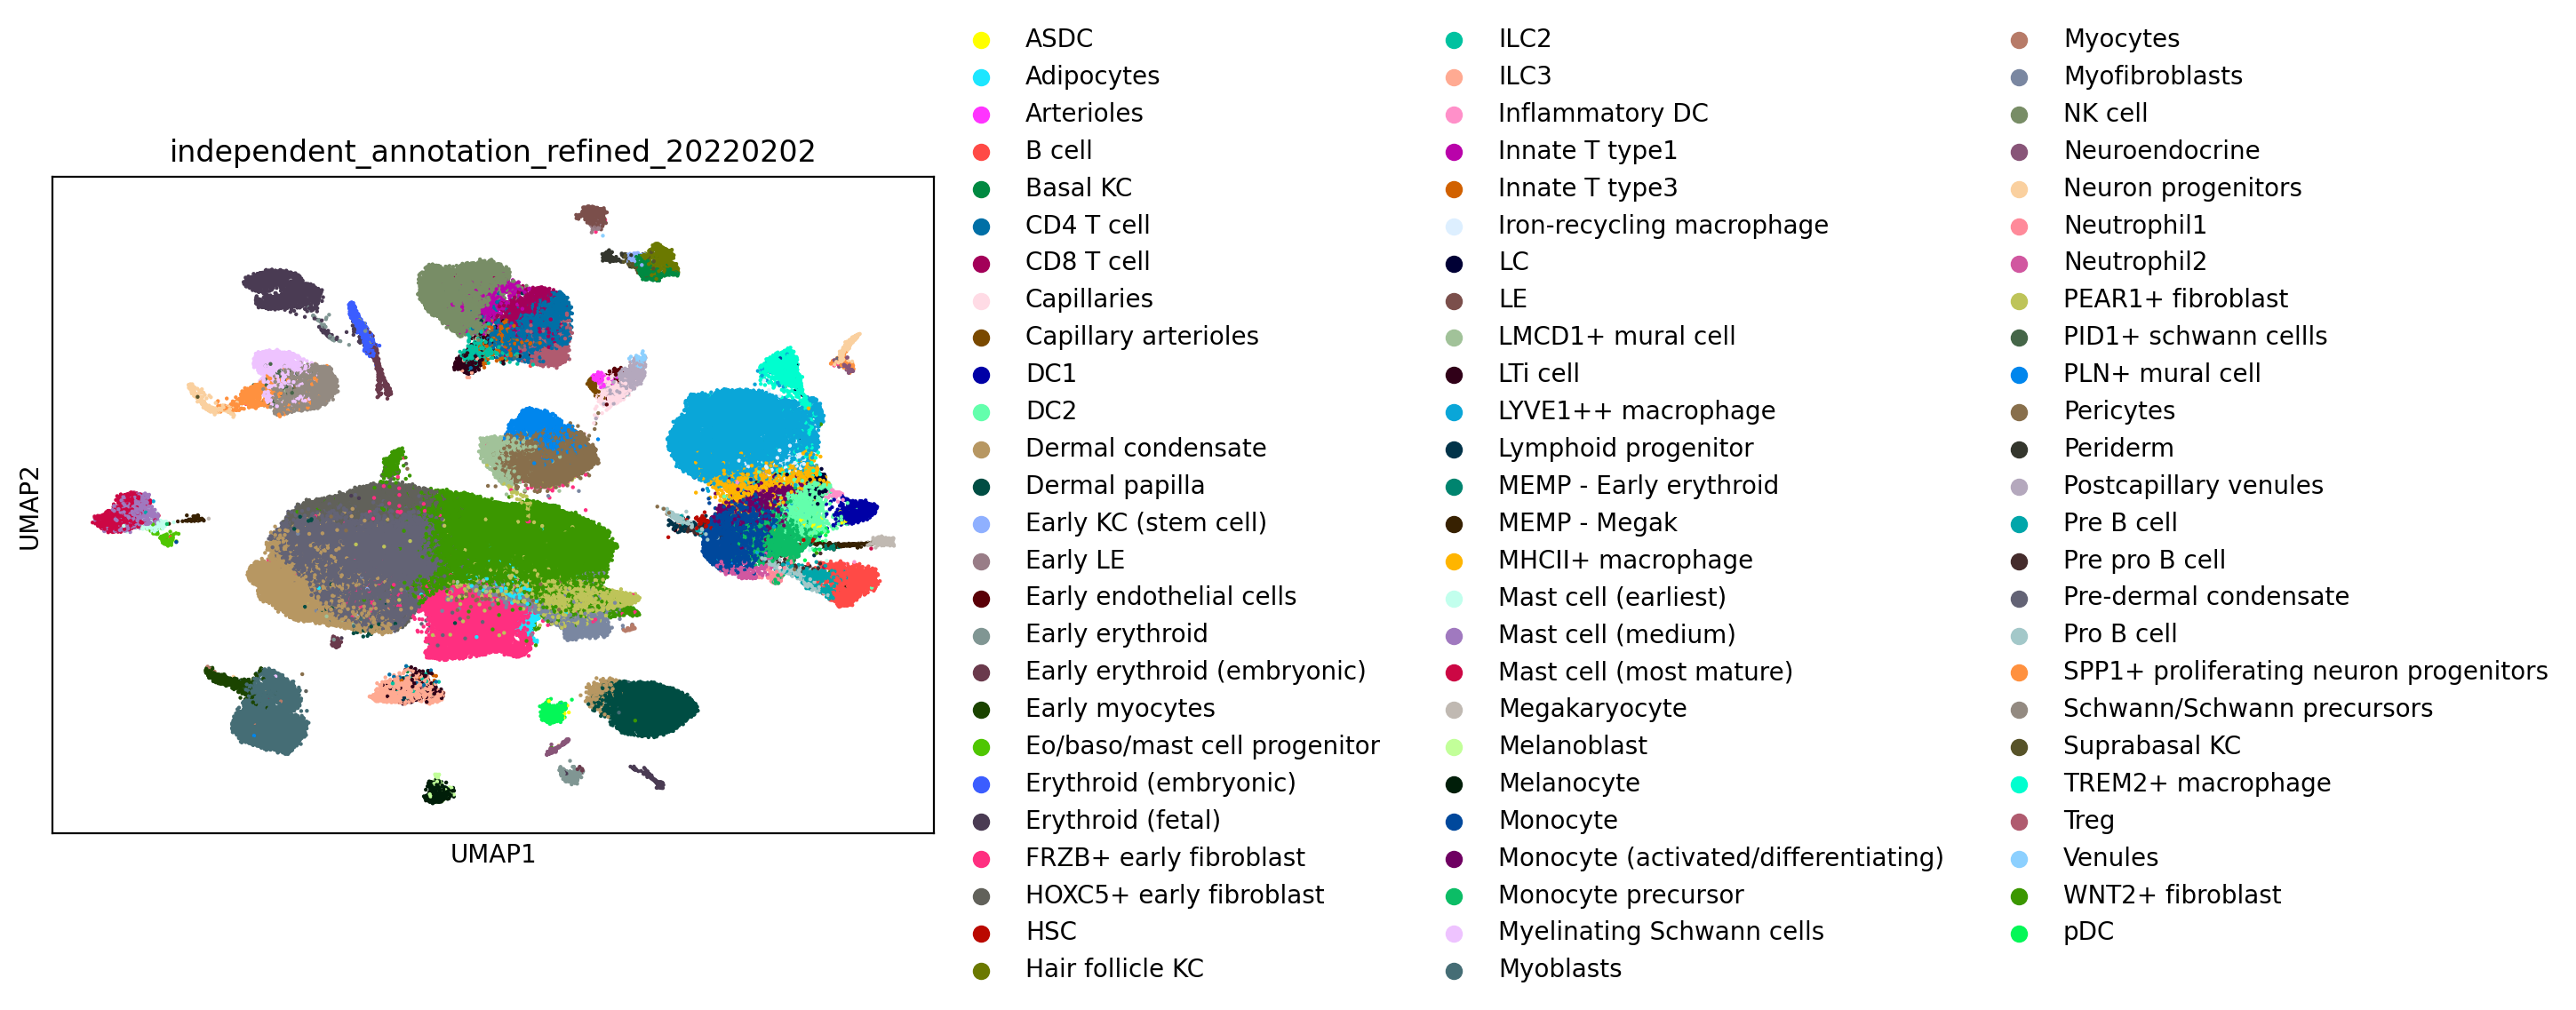

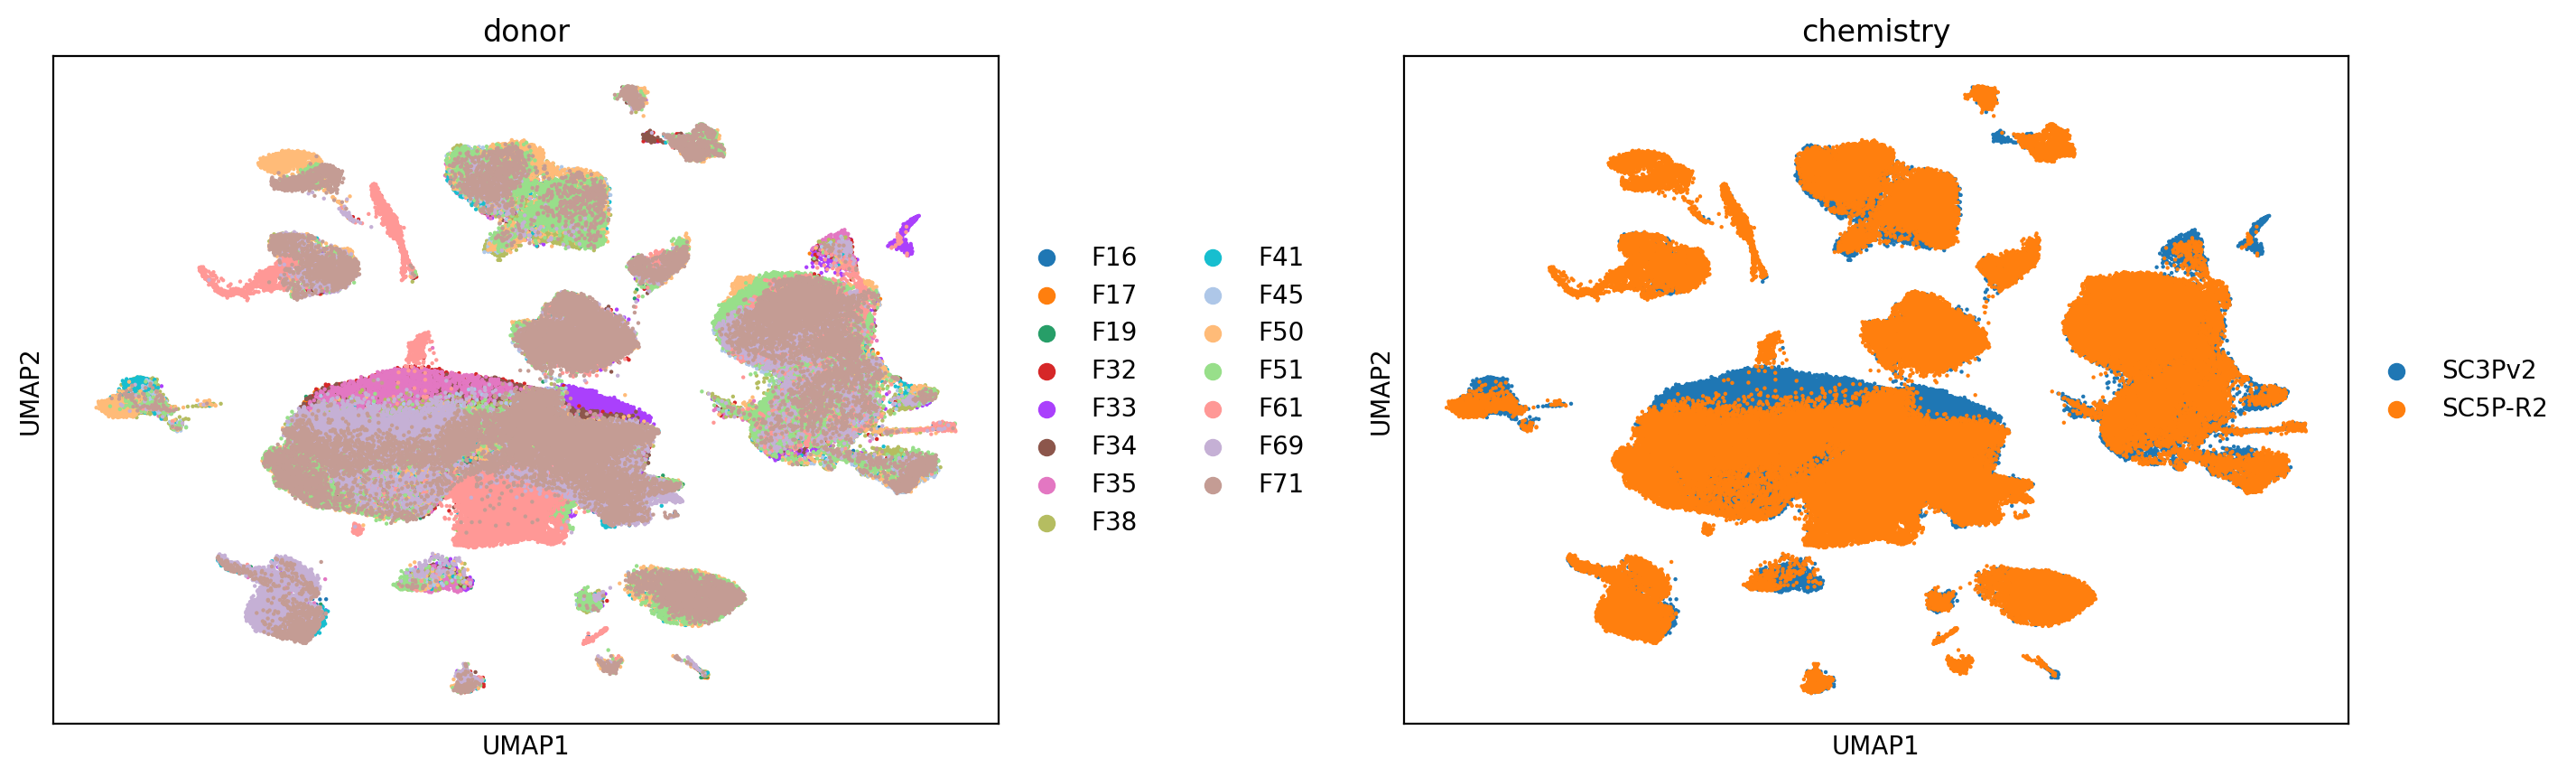

In [101]:
sc.tl.umap(adata, min_dist=0.3, spread=1.0,init_pos='spectral') # Using the default distance scaling from umap-learn
sc.pl.umap(adata,color = var_key,size =10)
sc.pl.umap(adata,color = batches,size =10,wspace=0.3)
adata.obsm['X_umap_disp_03'] = adata.obsm['X_umap']

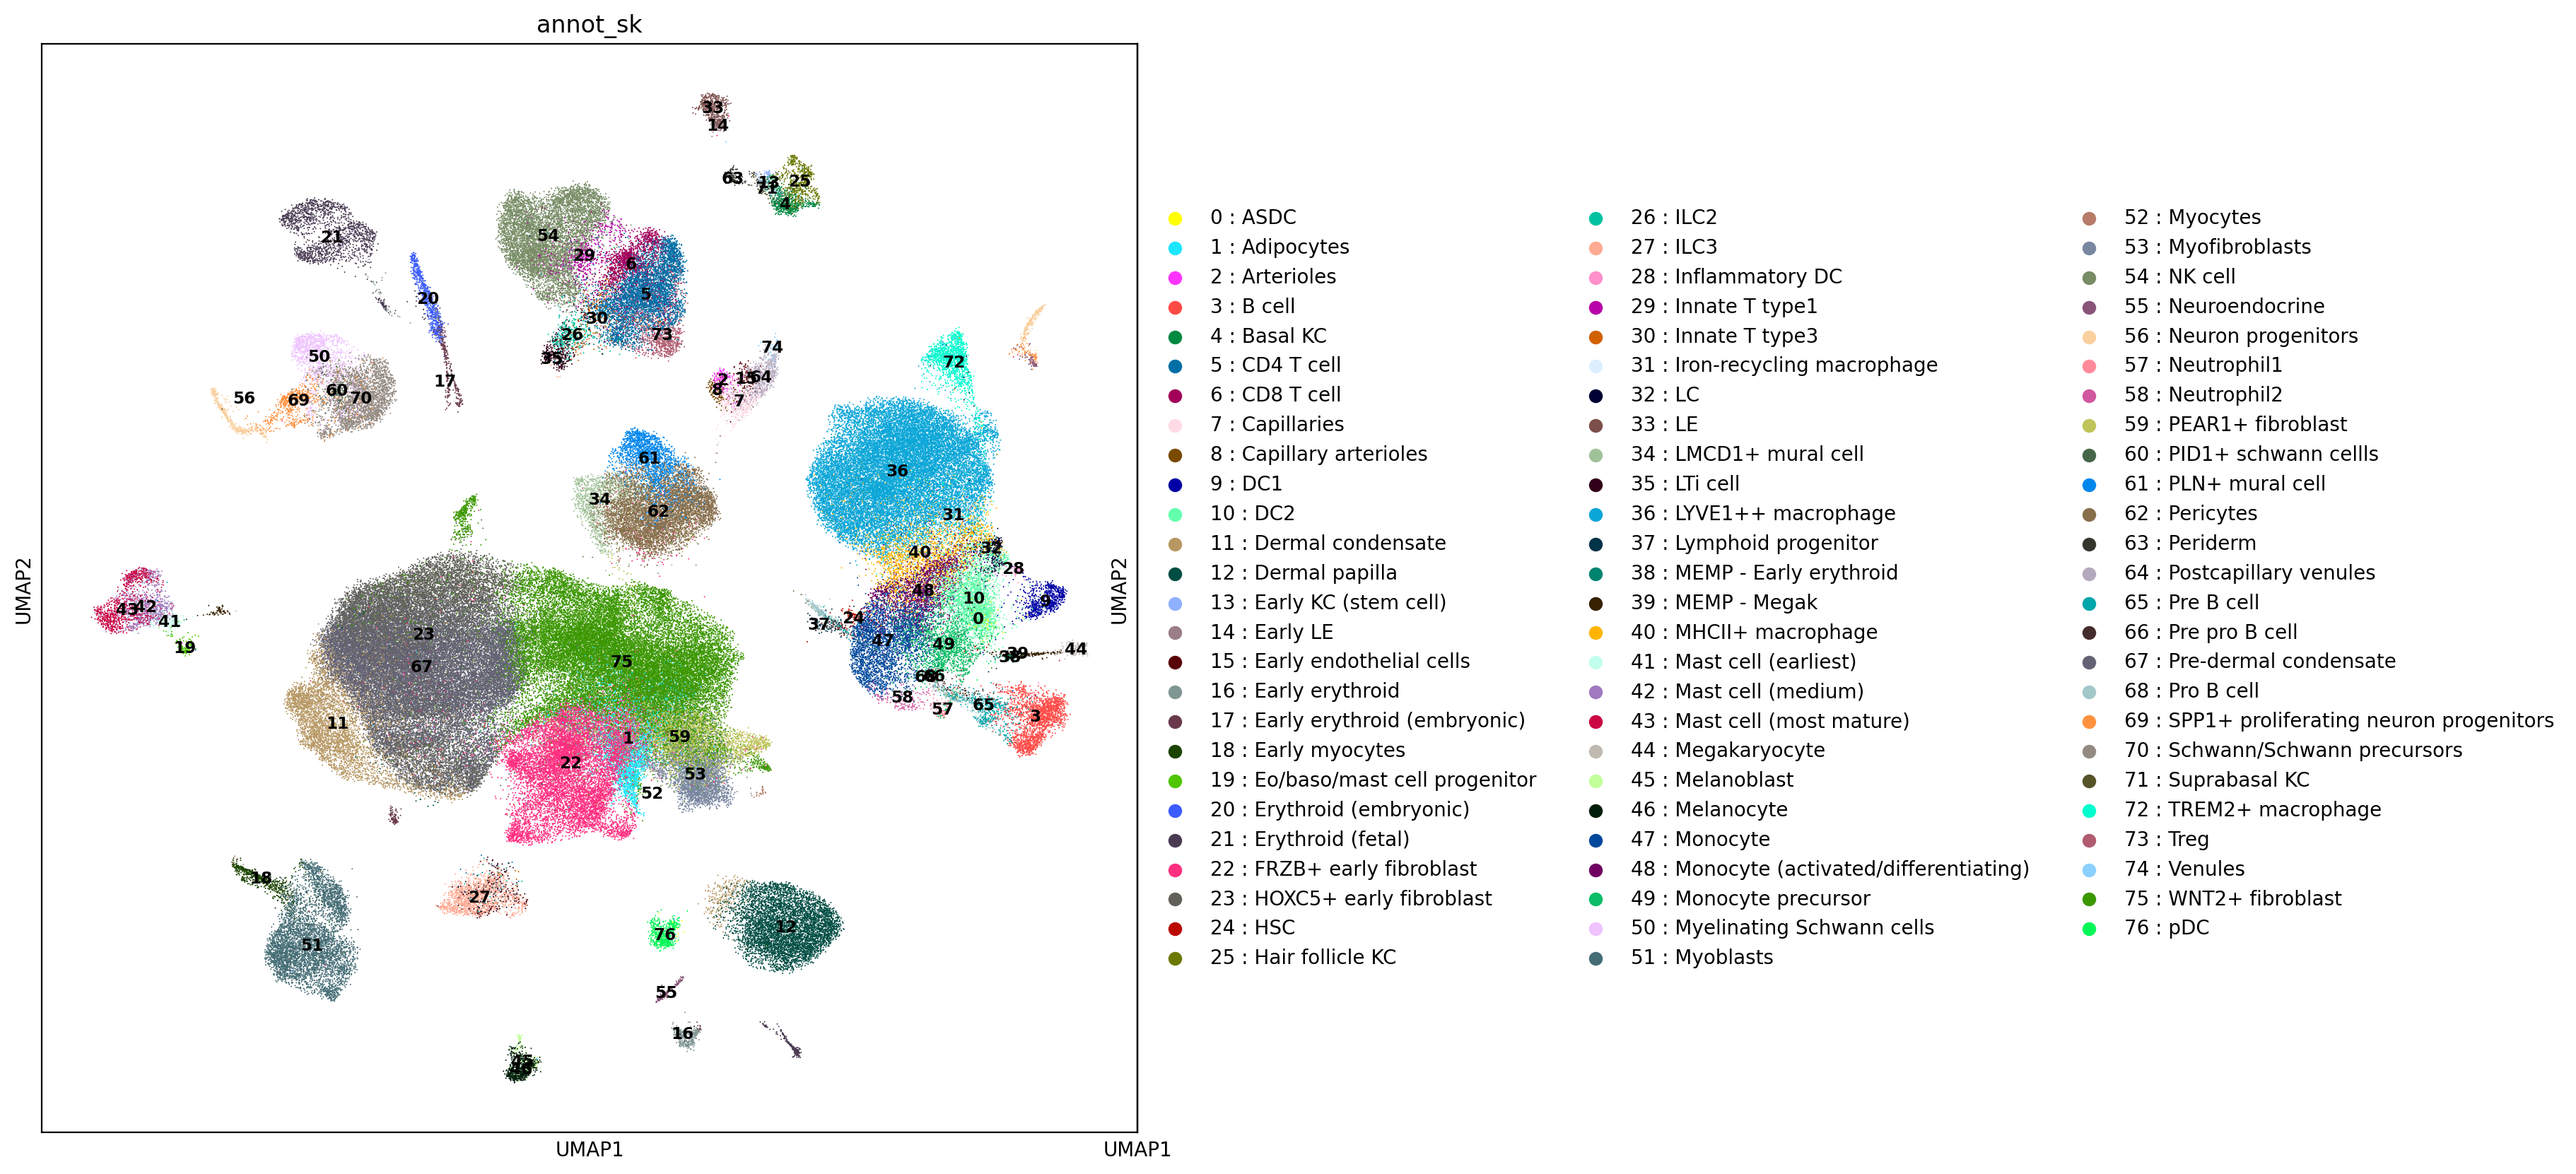

In [102]:
var = var_key
#Create color dictionary_cell
cells = list(adata.obs[var].cat.categories)
col = list(range(0, len(adata.obs[var].cat.categories)))
#col = adata.uns['cell.labels_colors']
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)
col_pal = adata.uns[var_key+'_colors']
plt.rcdefaults() #Reset matplot lb deafults as seaborne tends to mess with this
fig, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1,0]})
p2 = sc.pl.umap(adata, color = (var+'_num') ,ax=ax2,show=False,title="", palette= col_pal) #title=i
p3 = sc.pl.umap(adata, color = "num",legend_loc="on data",size=2,legend_fontsize='small',ax=ax1,show=False,title="annot_sk", palette= col_pal) #title=i
fig.savefig('./'+var+"_num.pdf",bbox_inches='tight')
plt.show()

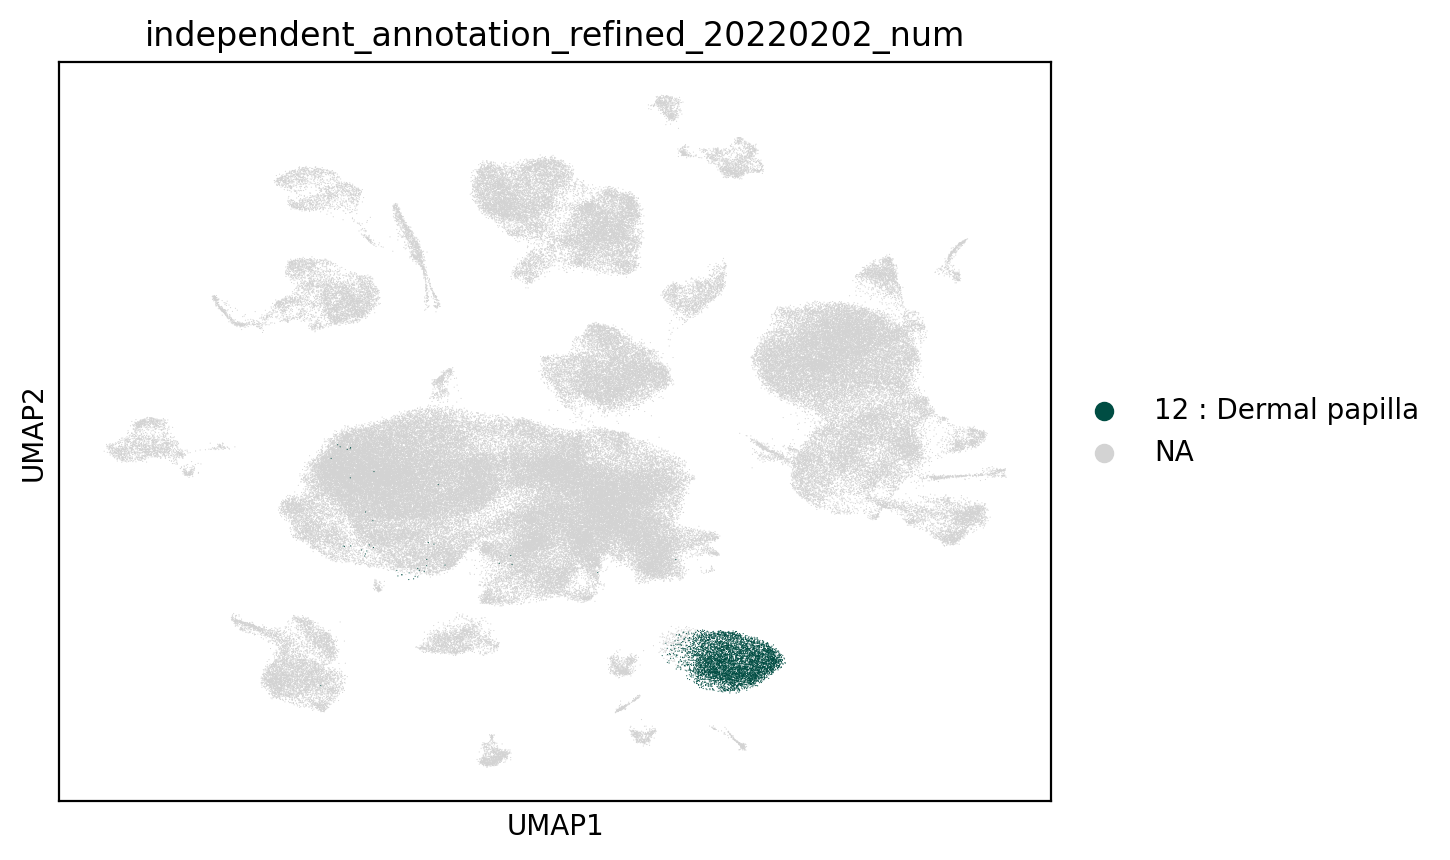

In [107]:
sc.pl.umap(adata,color = var+'_num',groups = ['12 : Dermal papilla',])

In [ ]:
adata.write(data['fski_qc_norm_scvi'])